i
---

In [6]:
import numpy as np
import pandas as pd

input_file = "../data/network_backup_dataset.csv"
df = pd.read_csv(input_file, header = 0)
labels = df.columns
for i, v in enumerate(labels):
    print "labels[" + str(i) + "] => " + v

labels[0] => Week #
labels[1] => Day of Week
labels[2] => Backup Start Time - Hour of Day
labels[3] => Work-Flow-ID
labels[4] => File Name
labels[5] => Size of Backup (GB)
labels[6] => Backup Time (hour)


In [7]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def convert_to_scalar(typeId, content):
    '''
    return the scalar encoding of the feature
    typeId 1 => Day of the week
    typeId 2 => Hour of the day
    typeId 3 => Work-flow number
    typeId 4 => File-type
    typeId 0 => Week number
    typeId 5 => Size of backup (GB)
    '''
    if typeId == 1:
        return week.index(content) + 1
    elif typeId == 2:
        return int(content)
    elif typeId == 3:
        return int(content.split('_')[2])
    elif typeId == 4:
        return int(content.split('_')[1])
    elif typeId == 0:
        return int(content)
    elif typeId == 5:
        return float(content)
    else:
        raise Exception('invalid typeId')
        
def transform_to_scalar(row):
    '''
    return a transformed scalar row
    parameter row is row in dataset
    '''
    a = []
    for i, v in enumerate(row[:6]):
        a.append(convert_to_scalar(i, v))

    return a

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_result(target, predict, title = ""):
    x = range(len(predict))
    
    area = np.pi * (1)**2  # 0 to 15 point radii
    plt.scatter(x, predict, color = 'red', s=area, label='prediction')
    plt.scatter(x, target, color = 'blue', s=area, label='True Value')
    plt.title("fitted values against true values")
    plt.legend()
    plt.show()
    
    plt.scatter(x, predict, color = 'red',s=area, label='prediction')
    plt.scatter(x, target - predict, color = 'blue', s=area, label='Residuals')
    plt.title("residuals versus fitted values")
    plt.legend()
    plt.show()

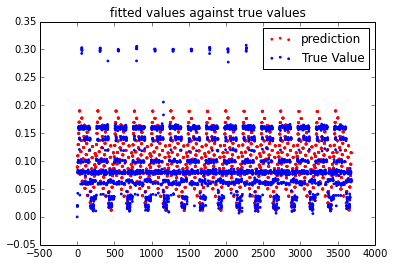

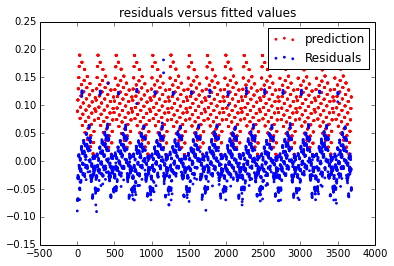

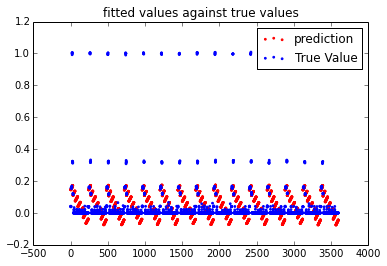

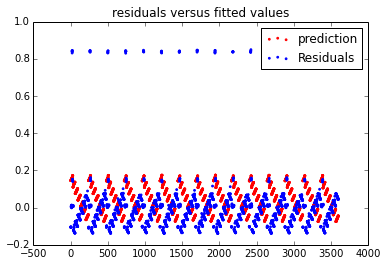

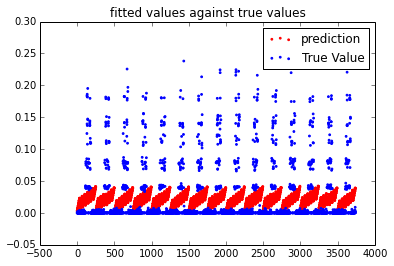

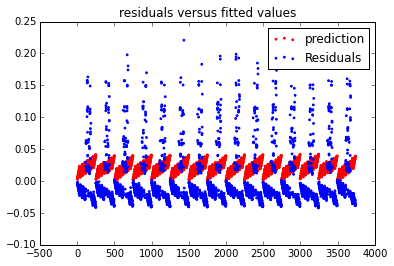

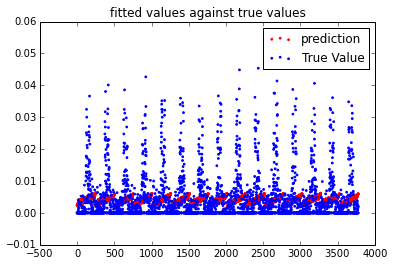

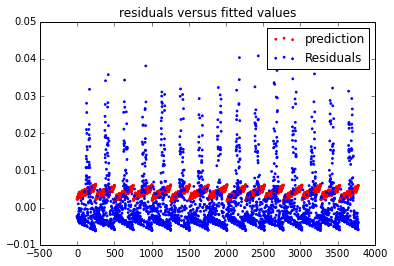

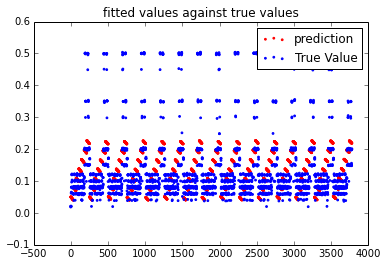

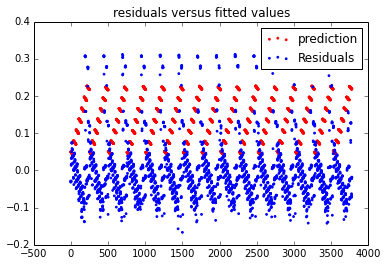

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_predict
from sklearn.model_selection import KFold

for work_flow_id, agg in df.groupby([labels[3]]):
    # get the scalar form of every work_file_id
    dataset_scalar = map(transform_to_scalar, agg.as_matrix())
    # get rid of the work_flow_id
    feature = map(lambda x: x[:3] + x[4:5], dataset_scalar)
    target = map(lambda x: x[5], dataset_scalar)
    
    predict = cross_val_predict(LinearRegression(), feature, target, cv = 10)
    title = str(work_flow_id)
    
    plot_result(target, predict, title)

ii
---

In [5]:
# get the rmse
def get_rmse(target, predict):
    n = len(predict)
    total = sum([(target[i] - predict[i])**2 for i in range(n)])
    return (total / n) ** 0.5

In [6]:
# plot the rmse 
def plot_rmse(degree, train_rmse, test_rmse, title):
    plt.plot(degree, train_rmse, label = "train_rmse")
    plt.plot(degree, test_rmse, label = "test_rmse")
    plt.title(title)
    plt.xlabel('degree of polynomial')
    plt.ylabel('RMSE')
    plt.legend(loc = 1, fancybox = True, framealpha = 0.5, prop = {'size': 8})
    plt.show()

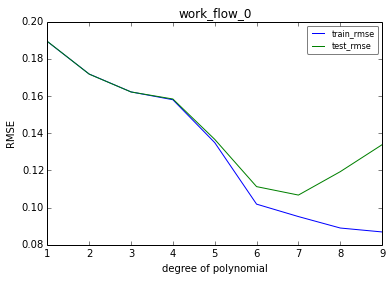

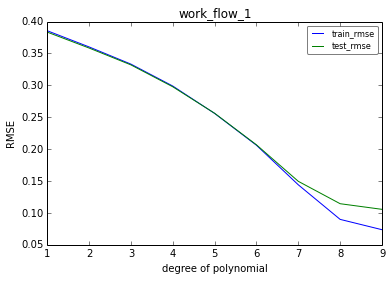

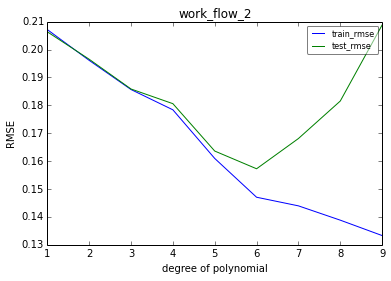

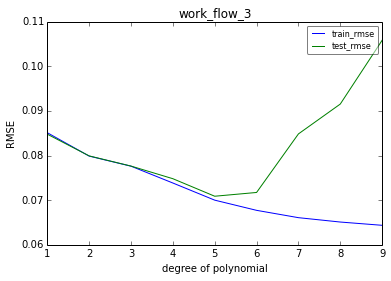

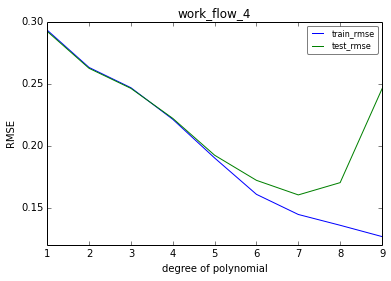

In [7]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

degree_of_poly = range(1, 10)
n_splits = 10
kf = KFold(n_splits = n_splits)

for work_flow_id, agg in df.groupby([labels[3]]):
    # get the scalar form of every work_file_id
    dataset_scalar = map(transform_to_scalar, agg.as_matrix())
    
    train_rmse = [0] * len(degree_of_poly)
    test_rmse = [0] * len(degree_of_poly)
    
    for train_index, test_index in kf.split(dataset_scalar):
        train_set = [dataset_scalar[i] for i in train_index]
        test_set = [dataset_scalar[i] for i in test_index]
        train = map(lambda x: x[:3] + x[4:5], train_set)
        train_target = map(lambda x: x[5], train_set)
        test = map(lambda x: x[:3] + x[4:5], test_set)
        test_target = map(lambda x: x[5], test_set)
        
        for i, degree in enumerate(degree_of_poly):
            polynomial_features = PolynomialFeatures(degree)
            linear_regression = LinearRegression()
            
            pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
            pipeline.fit(train, train_target)
            
            train_predict = pipeline.predict(train)
            test_predict = pipeline.predict(test)
            
            train_rmse[i] += get_rmse(train_target, train_predict)
            test_rmse[i] += get_rmse(test_target, test_predict)
            
    train_rmse = map(lambda x: (x / 10) ** 0.5, train_rmse)
    test_rmse = map(lambda x: (x / 10) ** 0.5, test_rmse)
    
    plot_rmse(degree_of_poly, train_rmse, test_rmse, work_flow_id)